In [2]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
import cycler
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import cmeutils
from cmeutils import structure

In [4]:
pcbm_path = "/home/gwenwhite/cmelab/projects/pcbm-project/"
project = signac.get_project(pcbm_path)

In [5]:
state_dict={"density":[1.2,'g/cm**3'], "kT_reduced":1.1, "tau":0.03}

job_list= project.find_jobs(state_dict)
for job in job_list:
    job_path = job.fn('trajectory.gsd')
    print(job)

cee4727b946f95c07a70412c4ec1fcca


In [10]:
def rdf_to_txt(job_list):
    for job in job_list:
        job_path = job.fn('trajectory.gsd')
        A_name = "c"
        B_name = "c"
        rdf, norm = structure.gsd_rdf(job_path, A_name, B_name, r_min=0.01, r_max=6)
        '''gsd_utils.gsd_rdf is a function from cme_lab_utils that creates the RDF'''
        x = rdf.bin_centers
        y = rdf.rdf*norm
        filename = job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
        np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        print(".txt file created for job:")
        print(job)

In [11]:
rdf_to_txt(job_list)

.txt file created for job:
cee4727b946f95c07a70412c4ec1fcca


In [12]:
def plot_txt(constant="den"): 
    if constant == "den":
        state_dict['density.$lt'] = (1.3, "g/cm**3")
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for kT,job in job_list.groupby('kT_reduced'):
            job = list(job)[0]
            A_name = "c"
            B_name = "c"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=kT)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['density']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    elif constant == "temp":
        state_dict['kT_reduced.$lt'] = 2.5
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for den,job in job_list.groupby('density'):
            job = list(job)[0]
            A_name = "c"
            B_name = "c"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=den)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("PCBM %s and %s's at %skT" % (A_name, B_name, job.sp['kT_reduced']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    elif constant == "both":
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.brg(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for mer,job in job_list.groupby('molecule'):
            job = list(job)[0]
            A_name = "c"
            B_name = "c"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=mer)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("PCBM %s and %s's at %sden %skT" % (A_name, B_name, job.sp['density'], job.sp['kT_reduced']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
        

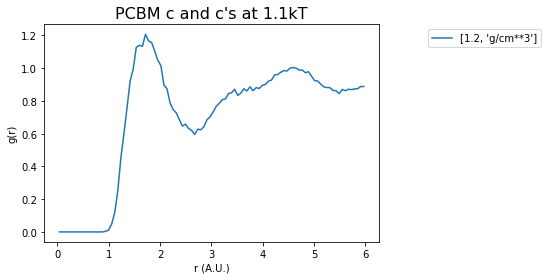

In [13]:
plot_txt(constant="temp") #constant= "den" for density, "temp" for temperature, "both" to compare polymer lengths at constant temperature and density

In [41]:
#1.2den around 1.2-1.5kT shows the highest peak